In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
names=[
    'tax_id', 
    'entry', 
    'taxonomy',
    'is_outlier',
    'is_odd',
    'gene',
    'location',
    'last_codon',
    'frameshift_stop'
    ]
tax_name = 'vertebrata'
df = pd.read_csv(
    f'genes_{tax_name}_new_release_oct_2023.csv', 
    names=names,
    sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93689 entries, 0 to 93688
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tax_id           93689 non-null  int64  
 1   entry            93689 non-null  object 
 2   taxonomy         0 non-null      float64
 3   is_outlier       93689 non-null  bool   
 4   is_odd           93689 non-null  bool   
 5   gene             93689 non-null  object 
 6   location         93689 non-null  object 
 7   last_codon       93611 non-null  object 
 8   frameshift_stop  7065 non-null   object 
dtypes: bool(2), float64(1), int64(1), object(5)
memory usage: 5.2+ MB


In [4]:
df.head()

,tax_id,entry,taxonomy,is_outlier,is_odd,gene,location,last_codon,frameshift_stop
0,156760,NC_036297.1,NaN,False,False,ATP6,[8018:8702](+),TAA,NaN
1,156760,NC_036297.1,NaN,False,False,ATP8,[7863:8028](+),TAA,NaN
2,156760,NC_036297.1,NaN,False,False,COX1,[5412:6963](+),AGG,AAGG
3,156760,NC_036297.1,NaN,False,False,COX2,[7107:7791](+),TAA,NaN
4,156760,NC_036297.1,NaN,False,False,COX3,[8701:9485](+),T,NaN


In [5]:
df.drop('taxonomy', axis=1, inplace=True)

In [6]:
df.nunique()

tax_id              7200
entry               7206
is_outlier             2
is_odd                 2
gene                  13
location           27528
last_codon            34
frameshift_stop       15
dtype: int64

for some species we have more than one refseq genome included. let's dicard then

In [7]:
# Drop duplicate rows based on 'tax_id' and 'entry'
df_unique = df.drop_duplicates(subset=['tax_id', 'entry'])

# Group by 'tax_id', and filter groups with size > 1
filtered_df = df_unique.groupby('tax_id').filter(lambda group: len(group) > 1).groupby('tax_id').count().reset_index()

duplicated_genomes = df.loc[df.tax_id.isin(filtered_df.tax_id)]

In [8]:
duplicated_genomes.nunique()

tax_id               6
entry               12
is_outlier           1
is_odd               1
gene                13
location           125
last_codon           6
frameshift_stop      6
dtype: int64

In [9]:
duplicated_genomes.to_csv(path_or_buf=f'{tax_name}_duplicates.csv', sep='\t', index=False)

discard the "duplicates"

In [10]:
df = df.loc[~df.tax_id.isin(filtered_df.tax_id)]

In [11]:
df.nunique()

tax_id              7194
entry               7194
is_outlier             2
is_odd                 2
gene                  13
location           27521
last_codon            34
frameshift_stop       15
dtype: int64

now look at those having != 13 genes.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93533 entries, 0 to 93688
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tax_id           93533 non-null  int64 
 1   entry            93533 non-null  object
 2   is_outlier       93533 non-null  bool  
 3   is_odd           93533 non-null  bool  
 4   gene             93533 non-null  object
 5   location         93533 non-null  object
 6   last_codon       93455 non-null  object
 7   frameshift_stop  7049 non-null   object
dtypes: bool(2), int64(1), object(5)
memory usage: 5.2+ MB


In [13]:
df_more_13 = df.groupby(['tax_id', 'entry']).filter(lambda x: len(x) > 13)
df_less_13 = df.groupby(['tax_id', 'entry']).filter(lambda x: len(x) < 13)
df_not_13 = df.groupby(['tax_id', 'entry']).filter(lambda x: len(x) != 13)

In [14]:
df_more_13.nunique()

tax_id              29
entry               29
is_outlier           1
is_odd               1
gene                13
location           371
last_codon           6
frameshift_stop      8
dtype: int64

In [15]:
df_less_13.nunique()

tax_id              20
entry               20
is_outlier           1
is_odd               1
gene                13
location           233
last_codon           7
frameshift_stop      5
dtype: int64

20 species have < 13 CDS, 29 species have > 13 CDS. Let's keep them for now.

In [16]:
# save non-13 counted records
df_not_13.to_csv(path_or_buf=f'{tax_name}_not_13_cds_records.csv', sep='\t', index=False)

what about odd records? non-canonical names, wrong taxonomy, not provided refseq sequence.

In [17]:
df[df.is_odd].nunique()

tax_id              6
entry               6
is_outlier          1
is_odd              1
gene               13
location           78
last_codon          0
frameshift_stop     0
dtype: int64

In [18]:
# save odd records
df[df.is_odd].to_csv(path_or_buf=f'{tax_name}_odd_records.csv', sep='\t', index=False)

how many have no seq provided?

In [19]:
df[df.is_odd & df.last_codon.isna()].nunique()

tax_id              6
entry               6
is_outlier          1
is_odd              1
gene               13
location           78
last_codon          0
frameshift_stop     0
dtype: int64

all these species have indeed no seq provided. dicard them as we have no info about their stops


In [20]:
df.dropna(subset=['last_codon'], inplace=True)

In [21]:
df.nunique()

tax_id              7188
entry               7188
is_outlier             2
is_odd                 1
gene                  13
location           27507
last_codon            34
frameshift_stop       15
dtype: int64

now see how many species have at least on AGA/AGG as a stop

In [22]:
df['has_non_canonical'] = df['last_codon'].isin(['AGA', 'AGG'])

In [23]:
df[df.tax_id == 9606]

,tax_id,entry,is_outlier,is_odd,gene,location,last_codon,frameshift_stop,has_non_canonical
71031,9606,NC_012920.1,False,False,ATP6,[8526:9207](+),TAA,NaN,False
71032,9606,NC_012920.1,False,False,ATP8,[8365:8572](+),TAG,NaN,False
71033,9606,NC_012920.1,False,False,COX1,[5903:7445](+),AGA,TAGA,True
71034,9606,NC_012920.1,False,False,COX2,[7585:8269](+),TAG,NaN,False
71035,9606,NC_012920.1,False,False,COX3,[9206:9990](+),T,NaN,False
71036,9606,NC_012920.1,False,False,CYTB,[14746:15887](+),T,NaN,False
71037,9606,NC_012920.1,False,False,ND1,[3306:4262](+),TA,NaN,False
71038,9606,NC_012920.1,False,False,ND2,[4469:5511](+),T,NaN,False
71039,9606,NC_012920.1,False,False,ND3,[10058:10404](+),T,NaN,False
71040,9606,NC_012920.1,False,False,ND4,[10759:12137](+),T,NaN,False


In [24]:
non_canonical_df = df.groupby('tax_id').agg({'has_non_canonical': 'max'}).reset_index().groupby(['has_non_canonical']).count().reset_index()

non_canonical_df

,has_non_canonical,tax_id
0,False,3220
1,True,3968


In [25]:
non_canonical_df.to_csv(path_or_buf=f'{tax_name}_non_canonical_counts.csv', sep='\t', index=False)

among those having at least one aga/agg, how many have at least one aga/agg not resulting in tag/taa with -1fs?

now  we can group by genes, stops, frameshifts, and look at the counts for each group

In [27]:
df['last_codon_aggd'] = df.last_codon.apply(lambda x: 'T/TA' if x in ('T', 'TA') else x)
df['frameshift_stop_aggd'] = df.loc[:, 'frameshift_stop']
df.loc[df.frameshift_stop_aggd.notna(), 'frameshift_stop_aggd'] = df.loc[df.frameshift_stop_aggd.notna(), 'frameshift_stop_aggd'].apply(lambda x: np.nan if len(x) < 4 else x)
df.loc[df.frameshift_stop_aggd.notna(), 'frameshift_stop_aggd'] = df.loc[df.frameshift_stop_aggd.notna(), 'frameshift_stop_aggd'].apply(lambda x: x[:-1] if len(x) == 4 else x)


df[df.tax_id == 7753]

,tax_id,entry,is_outlier,is_odd,gene,location,last_codon,frameshift_stop,has_non_canonical,last_codon_aggd,frameshift_stop_aggd
80598,7753,NC_014270.1,False,False,ATP6,[9224:9938](+),AGA,TAGA,True,AGA,TAG
80599,7753,NC_014270.1,False,False,ATP8,[9066:9234](+),TAG,NaN,False,TAG,NaN
80600,7753,NC_014270.1,False,False,COX1,[6606:8160](+),AGA,AAGA,True,AGA,AAG
80601,7753,NC_014270.1,False,False,COX2,[8294:8978](+),AGA,TAGA,True,AGA,TAG
80602,7753,NC_014270.1,False,False,COX3,[9903:10689](+),TAA,NaN,False,TAA,NaN
80603,7753,NC_014270.1,False,False,CYTB,[0:1191](+),AGA,TAGA,True,AGA,TAG
80604,7753,NC_014270.1,False,False,ND1,[4004:4970](+),TAA,NaN,False,TAA,NaN
80605,7753,NC_014270.1,False,False,ND2,[5209:6251](+),T,NaN,False,T/TA,NaN
80606,7753,NC_014270.1,False,False,ND3,[10767:11118](+),TAA,NaN,False,TAA,NaN
80607,7753,NC_014270.1,False,False,ND4,[11480:12857](+),AGA,TAGA,True,AGA,TAG


In [28]:
df[df.last_codon == 'AGG']

,tax_id,entry,is_outlier,is_odd,gene,location,last_codon,frameshift_stop,has_non_canonical,last_codon_aggd,frameshift_stop_aggd
2,156760,NC_036297.1,False,False,COX1,[5412:6963](+),AGG,AAGG,True,AGG,AAG
6,156760,NC_036297.1,False,False,ND1,[2803:3781](+),AGG,AAGG,True,AGG,AAG
7,156760,NC_036297.1,False,False,ND2,[3999:5049](+),AGG,TAGG,True,AGG,TAG
67,311900,NC_028404.1,False,False,COX1,[5357:6905](+),AGG,GAGG,True,AGG,GAG
71,311900,NC_028404.1,False,False,ND1,[2757:3738](+),AGG,AAGG,True,AGG,AAG
...,...,...,...,...,...,...,...,...,...,...,...
93440,2546036,NC_081041.1,False,False,ND6,[13795:14317](-),AGG,TAGG,True,AGG,TAG
93453,1206991,NC_081042.1,False,False,ND6,[13876:14395](-),AGG,TAGG,True,AGG,TAG
93465,1502862,NC_081043.1,False,False,ND5,[12009:13854](+),AGG,AAGG,True,AGG,AAG
93466,1502862,NC_081043.1,False,False,ND6,[13837:14359](-),AGG,AAGG,True,AGG,AAG


In [31]:
df['has_stop_fs'] = df.frameshift_stop_aggd == 'TAG'

In [37]:
df['can_be_terminated'] = (df.has_non_canonical & df.has_stop_fs) | ~df.has_non_canonical


df[df.tax_id == 7753]

,tax_id,entry,is_outlier,is_odd,gene,location,last_codon,frameshift_stop,has_non_canonical,last_codon_aggd,frameshift_stop_aggd,can_be_terminated,has_stop_fs
80598,7753,NC_014270.1,False,False,ATP6,[9224:9938](+),AGA,TAGA,True,AGA,TAG,True,True
80599,7753,NC_014270.1,False,False,ATP8,[9066:9234](+),TAG,NaN,False,TAG,NaN,True,False
80600,7753,NC_014270.1,False,False,COX1,[6606:8160](+),AGA,AAGA,True,AGA,AAG,False,False
80601,7753,NC_014270.1,False,False,COX2,[8294:8978](+),AGA,TAGA,True,AGA,TAG,True,True
80602,7753,NC_014270.1,False,False,COX3,[9903:10689](+),TAA,NaN,False,TAA,NaN,True,False
80603,7753,NC_014270.1,False,False,CYTB,[0:1191](+),AGA,TAGA,True,AGA,TAG,True,True
80604,7753,NC_014270.1,False,False,ND1,[4004:4970](+),TAA,NaN,False,TAA,NaN,True,False
80605,7753,NC_014270.1,False,False,ND2,[5209:6251](+),T,NaN,False,T/TA,NaN,True,False
80606,7753,NC_014270.1,False,False,ND3,[10767:11118](+),TAA,NaN,False,TAA,NaN,True,False
80607,7753,NC_014270.1,False,False,ND4,[11480:12857](+),AGA,TAGA,True,AGA,TAG,True,True


In [38]:
non_canonical_df = df.groupby('tax_id').agg({'can_be_terminated': 'min'}).reset_index().groupby(['can_be_terminated']).count().reset_index()

# non_canonical_df = df.groupby(['tax_id', 'has_non_canonical', 'has_stop_fs']).count().reset_index()

non_canonical_df

,can_be_terminated,tax_id
0,False,3497
1,True,3691


In [40]:
non_canonical_df = df.groupby('tax_id').agg({'can_be_terminated': 'min', 'has_non_canonical': 'max'}).reset_index().groupby(['can_be_terminated', 'has_non_canonical']).count().reset_index()

# non_canonical_df = df.groupby(['tax_id', 'has_non_canonical', 'has_stop_fs']).count().reset_index()

non_canonical_df

,can_be_terminated,has_non_canonical,tax_id
0,False,True,3497
1,True,False,3220
2,True,True,471


In [42]:
pivot = non_canonical_df.pivot(index='has_non_canonical', columns='can_be_terminated', values='tax_id').fillna(0)
pivot

can_be_terminated,False,True
has_non_canonical,,
False,0.0,3220.0
True,3497.0,471.0


In [135]:
# Group by 'gene' and 'last_codon', and get counts of the entries
stop_counts = df.groupby(['gene', 'last_codon_aggd', 'frameshift_stop_aggd'], dropna=False).size().reset_index(name='counts')

In [136]:
stop_counts.head()

,gene,last_codon_aggd,frameshift_stop_aggd,counts
0,ATP6,A,NaN,6
1,ATP6,AGA,TAG,27
2,ATP6,AGG,AAG,1
3,ATP6,AGG,CAG,3
4,ATP6,AGG,TAG,1


save the stops statistics

In [137]:
stop_counts.to_csv(path_or_buf=f'{tax_name}_stops_aggregated.csv', sep='\t', index=False)

In [138]:
# Calculate the sum of counts for each gene
gene_counts_sum = stop_counts.groupby('gene')['counts'].transform('sum')

# Calculate the percentage of counts for each row
stop_counts['percentage'] = (stop_counts['counts'] / gene_counts_sum) * 100


In [139]:
stop_counts.head(10)

,gene,last_codon_aggd,frameshift_stop_aggd,counts,percentage
0,ATP6,A,NaN,6,0.083472
1,ATP6,AGA,TAG,27,0.375626
2,ATP6,AGG,AAG,1,0.013912
3,ATP6,AGG,CAG,3,0.041736
4,ATP6,AGG,TAG,1,0.013912
5,ATP6,C,NaN,2,0.027824
6,ATP6,GA,NaN,1,0.013912
7,ATP6,T/TA,NaN,1469,20.436839
8,ATP6,TAA,NaN,5599,77.893712
9,ATP6,TAG,NaN,78,1.085142


In [140]:
stop_counts.nunique()

gene                     13
last_codon_aggd          33
frameshift_stop_aggd      5
counts                   82
percentage              101
dtype: int64

In [141]:
# Group by both 'gene' and 'last_codon', and sum the percentages
df_grouped = stop_counts.groupby(['gene', 'last_codon_aggd'])['percentage'].sum().reset_index()

# Pivot the DataFrame
df_pivot = df_grouped.pivot(index='gene', columns='last_codon_aggd', values='percentage').fillna(0)

# Filter columns where all values are below the threshold
threshold = 0.5
filtered_df_pivot = df_pivot.loc[:, (df_pivot > threshold).any(axis=0)]

filtered_df_pivot

last_codon_aggd,AGA,AGG,T/TA,TAA,TAG
gene,,,,,
ATP6,0.375626,0.069560,20.436839,77.893712,1.085142
ATP8,0.027844,0.041765,0.445496,84.880969,14.590004
COX1,6.274346,25.445186,1.572065,60.726210,5.676127
COX2,0.542646,0.069570,63.086128,34.019758,2.184500
COX3,0.013910,0.013910,92.168591,6.982891,0.695507
CYTB,13.693293,1.308099,54.119121,26.649040,3.771222
ND1,5.036872,7.680534,26.506192,44.413524,16.307221
ND2,0.612131,0.180857,79.326656,11.533111,8.235949
ND3,0.069580,0.083496,74.450320,19.496243,5.733370


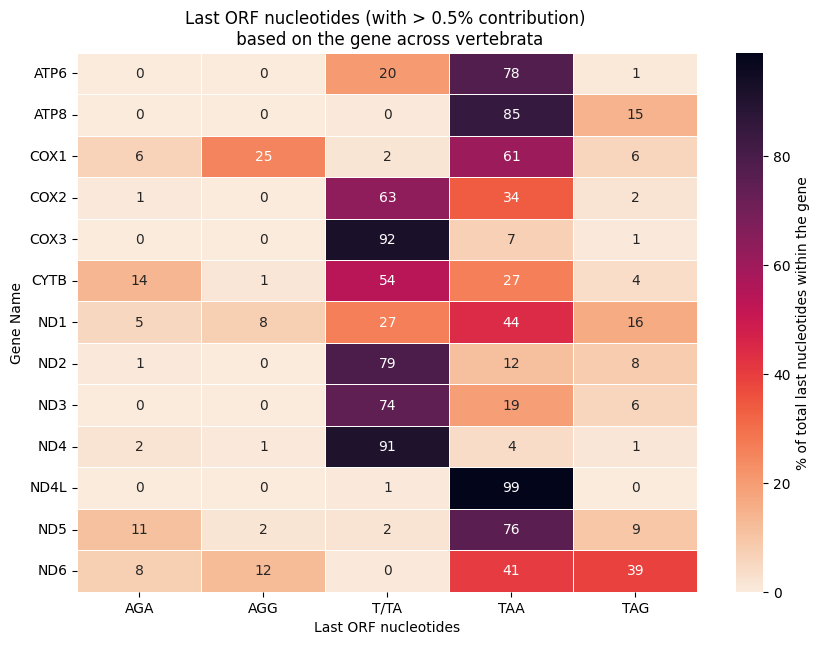

In [142]:
# Create the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(filtered_df_pivot, annot=True, fmt=".0f", cmap="rocket_r", linewidths=.5)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Set axis titles
ax.set_xlabel("Last ORF nucleotides")
ax.set_ylabel("Gene Name")

# Set plot title and increase the gap
title = ax.set_title(f"Last ORF nucleotides (with > {threshold}% contribution) \n based on the gene across {tax_name}")
title_pos = title.get_position()
title.set_position([title_pos[0], title_pos[1] + 5])

# Set colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('% of total last nucleotides within the gene')

# Save the plot as a high-resolution image
plt.savefig(f"gene_vs_stop_{tax_name}_v2.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [143]:
frameshifts = stop_counts.groupby(['last_codon_aggd', 'frameshift_stop_aggd']).sum(numeric_only=True).reset_index().drop('percentage', axis=1)

# Calculate the sum of counts for each gene
codon_counts_sum = frameshifts.groupby('last_codon_aggd')['counts'].transform('sum')

# Calculate the percentage of counts for each row
frameshifts['percentage'] = (frameshifts['counts'] / codon_counts_sum) * 100

In [144]:
# Pivot the DataFrame
frameshifts_pivot = frameshifts.pivot(index='last_codon_aggd', columns='frameshift_stop_aggd', values='percentage').fillna(0)

frameshifts_pivot

frameshift_stop_aggd,AAG,CAG,GAG,NAG,TAG
last_codon_aggd,,,,,
AGA,56.583942,17.021898,6.481752,0.058394,19.854015
AGG,70.913663,2.570550,5.532272,0.000000,20.983515


In [145]:
threshold = 0.5
filtered_df_pivot = frameshifts_pivot.loc[:, (frameshifts_pivot > threshold).any(axis=0)]

filtered_df_pivot

frameshift_stop_aggd,AAG,CAG,GAG,TAG
last_codon_aggd,,,,
AGA,56.583942,17.021898,6.481752,19.854015
AGG,70.913663,2.570550,5.532272,20.983515


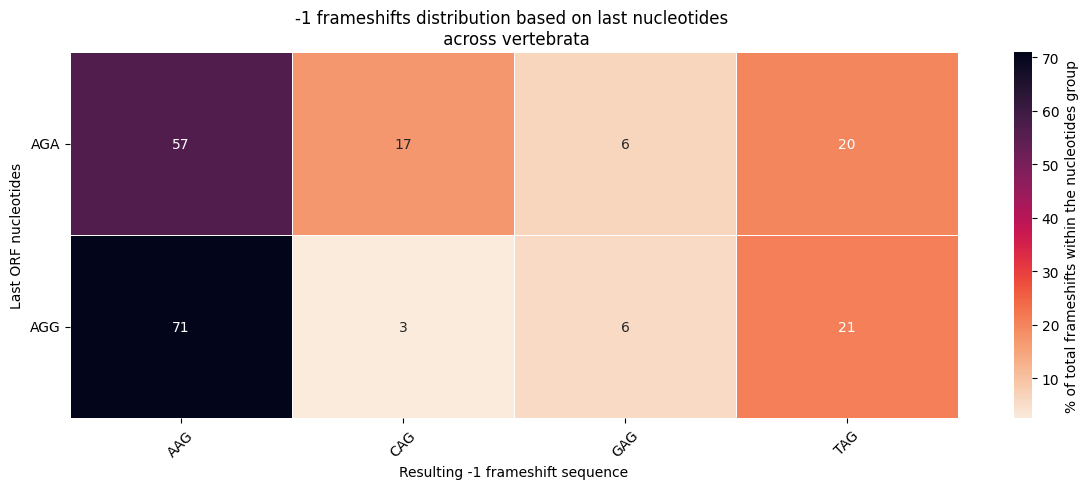

In [146]:
# Create the heatmap
plt.figure(figsize=(12, 5))
ax = sns.heatmap(filtered_df_pivot, annot=True, fmt=".0f", cmap="rocket_r", linewidths=.5)

# Rotate y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Set axis titles
ax.set_xlabel("Resulting -1 frameshift sequence")
ax.set_ylabel("Last ORF nucleotides")

# Set plot title
ax.set_title(f"-1 frameshifts distribution based on last nucleotides \n across {tax_name}")

# Set colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('% of total frameshifts within the nucleotides group')

# Save the plot as a high-resolution image
plt.savefig(f"stop_vs_frameshift_{tax_name}_v2.png", dpi=300, bbox_inches='tight')

plt.tight_layout()